In [86]:
import random
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import matplotlib.pyplot as plt
import gymnasium as gym
import imageio
from collections import deque
from IPython.display import Video

from tetris_gymnasium.envs.tetris import Tetris
from tetris_gymnasium.wrappers.grouped import GroupedActionsObservations
from tetris_gymnasium.mappings.rewards import RewardsMapping

In [87]:
def make_custom_tetris_env(
    alife=1.0,           # Much stronger survival incentive
    clear_line=50,      # Higher line clearing reward
    game_over=-50,       # Stronger game over penalty
    invalid_action=-5,   # Stronger illegal action penalty
):

    # Create custom reward map
    custom_map = RewardsMapping(
        alife=alife,
        clear_line=clear_line,
        game_over=game_over,
        invalid_action=invalid_action
    )

    # Initialize env with reward override
    env = gym.make(
        "tetris_gymnasium/Tetris",
        rewards_mapping=custom_map,
        # render_mode="rgb_array"  # Uncomment if needed
    )
    
    env = GroupedActionsObservations(env)
    
    return env

In [88]:
env = make_custom_tetris_env()

obs, info = env.reset()
print("Action space:", env.action_space)
print("Observation shape:", obs.shape)

Action space: Discrete(40)
Observation shape: (40, 24, 18)


In [89]:
class DQN_MLP(nn.Module):
    def __init__(self, input_dim, num_actions):
        super(DQN_MLP, self).__init__()
        self.fc1 = nn.Linear(input_dim, 512)
        self.fc2 = nn.Linear(512, 256)
        self.fc3 = nn.Linear(256, 128)
        self.out = nn.Linear(128, num_actions)

    def forward(self, x):
        # x: [batch_size, input_dim]
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = F.relu(self.fc3(x))
        return self.out(x)


In [90]:
class PrioritizedReplayMemory:
    def __init__(self, capacity, device, alpha=0.6, beta_start=0.4, beta_frames=100000):
        self.capacity = capacity
        self.memory = []
        self.priorities = np.zeros((capacity,), dtype=np.float32)
        self.position = 0
        self.device = device
        
        # PER hyperparameters
        self.alpha = alpha          # Controls how strongly prioritized sampling is (0 = uniform)
        self.beta = beta_start      # Importance sampling correction factor
        self.beta_increment = (1.0 - beta_start) / beta_frames  # Gradually increase β

    def push(self, state, action, reward, next_state, done):
        """Store transition and assign max priority initially."""
        max_priority = self.priorities.max() if self.memory else 1.0

        if len(self.memory) < self.capacity:
            self.memory.append((state, action, reward, next_state, done))
        else:
            self.memory[self.position] = (state, action, reward, next_state, done)

        self.priorities[self.position] = max_priority
        self.position = (self.position + 1) % self.capacity

    def sample(self, batch_size):
        """Sample using probability distribution from priorities."""
        if len(self.memory) == self.capacity:
            prios = self.priorities
        else:
            prios = self.priorities[:self.position]

        # Compute probabilities (p_i^α / Σ p_j^α)
        probs = prios ** self.alpha
        probs /= probs.sum()

        # Draw indices according to probabilities
        indices = np.random.choice(len(self.memory), batch_size, p=probs)
        batch = [self.memory[idx] for idx in indices]

        # Convert sampled batch to tensors
        states, actions, rewards, next_states, dones = zip(*batch)
        states = torch.tensor(np.array(states), dtype=torch.float32).to(self.device, non_blocking=True)
        next_states = torch.tensor(np.array(next_states), dtype=torch.float32).to(self.device, non_blocking=True)
        actions = torch.tensor(actions, dtype=torch.long).to(self.device, non_blocking=True)
        rewards = torch.tensor(rewards, dtype=torch.float32).to(self.device, non_blocking=True)
        dones = torch.tensor(dones, dtype=torch.float32).to(self.device, non_blocking=True)

        # Compute importance-sampling (IS) weights
        total = len(self.memory)
        self.beta = min(1.0, self.beta + self.beta_increment)
        weights = (total * probs[indices]) ** (-self.beta)
        weights = torch.tensor(weights / weights.max(), dtype=torch.float32).to(self.device, non_blocking=True)

        return states, actions, rewards, next_states, dones, indices, weights

    def update_priorities(self, indices, td_errors):
        """Update sampled indices with new priority (|TD error|)."""
        for idx, error in zip(indices, td_errors):
            self.priorities[idx] = abs(error) + 1e-5  # small epsilon avoids zero priority

    def __len__(self):
        return len(self.memory)


In [91]:
def train_step(policy_dqn, target_dqn, memory, optimizer, gamma=0.999, batch_size=32, device="cpu"):
    if len(memory) < batch_size:
        return

    # ✅ PER-aware sampling
    sample_output = memory.sample(batch_size)

    if len(sample_output) == 7:
        states, actions, rewards, next_states, dones, indices, weights = sample_output
        per_enabled = True
    else:  # Fallback if using normal replay buffer
        states, actions, rewards, next_states, dones = sample_output
        indices, weights = None, None
        per_enabled = False

    # Flatten states for MLP
    states = states.view(batch_size, -1).to(device, non_blocking=True)
    next_states = next_states.view(batch_size, -1).to(device, non_blocking=True)
    actions = actions.to(device, non_blocking=True)
    rewards = rewards.to(device, non_blocking=True)
    dones = dones.to(device, non_blocking=True)

    # Compute Q-values
    q_pred = policy_dqn(states).gather(1, actions.unsqueeze(1)).squeeze(1)

    with torch.no_grad():
        q_next = target_dqn(next_states).max(1)[0]
        q_target = rewards + gamma * q_next * (1 - dones)

    # ✅ Compute TD error (needed for priority update)
    td_errors = q_target - q_pred

    # ✅ Apply PER loss or normal MSE loss
    if per_enabled:
        loss = (td_errors.pow(2) * weights).mean()
    else:
        loss = F.mse_loss(q_pred, q_target)

    optimizer.zero_grad(set_to_none=True)
    loss.backward()
    optimizer.step()

    # ✅ Update priorities in replay buffer (only if PER enabled)
    if per_enabled:
        memory.update_priorities(indices, td_errors.detach().cpu().numpy())

In [92]:
# device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# obs, _ = env.reset()
# obs_shape = np.prod(obs.shape)
# num_actions = env.action_space.n

# policy_dqn = DQN_MLP(obs_shape, num_actions).to(device)
# target_dqn = DQN_MLP(obs_shape, num_actions).to(device)
# target_dqn.load_state_dict(policy_dqn.state_dict())

# optimizer = optim.Adam(policy_dqn.parameters(), lr=1e-4)
# buffer_size=10000
# memory = ReplayMemory(buffer_size, device=device)

# epsilon = 1.0  # exploration rate
# epsilon_min = 0.1
# epsilon_decay = 0.995
# episodes = 500

# lines_cleared = 0
# rewards_history = []
# lines_history = []

# for ep in range(episodes):
#     obs, info = env.reset()
#     done = False

#     total_reward = 0

#     while not done:
#         obs_tensor = torch.tensor(obs, dtype=torch.float32, device=device).unsqueeze(0)
#         obs_flat = obs_tensor.flatten(start_dim=1)  # [1, 17280]
#         q_values = policy_dqn(obs_flat)
        
#         if np.random.rand() < epsilon:
#             action = np.random.randint(num_actions)
#         else:
#             action = q_values.argmax(dim=1).item()
        
#         next_obs, reward, terminated, truncated, info = env.step(action)
#         done = terminated or truncated
#         total_reward += reward
#         lines_cleared += info["lines_cleared"]

#         memory.push(obs, action, reward, next_obs, done)
#         obs = next_obs
        
#         train_step(policy_dqn, target_dqn, memory, optimizer, device=device)
    
#         rewards_history.append(total_reward)
#         lines_history.append(lines_cleared)
        
#     # epsilon = epsilon_end + (epsilon_start - epsilon_end) * np.exp(-steps_done / epsilon_decay)
#     epsilon = max(epsilon_min, epsilon * epsilon_decay)
#     if ep % 10 == 0:
#         target_dqn.load_state_dict(policy_dqn.state_dict())

#     print(f"Episode {ep} — Total reward: {total_reward:.2f}, lines cleared: {lines_cleared}, ε={epsilon:.2f}")

In [93]:
import numpy as np

def calculate_holes(board: np.ndarray) -> int:
    '''
    Calculate the number of visible holes in a Tetris board.
    A hole is an empty cell (0) that has at least one filled cell (non-zero)
    above it in the same column, but only below the surface of the board.
    '''
    rows, cols = board.shape
    holes = 0
    
    # For each column, find holes below the surface
    for col in range(cols):
        # Find all filled cells in this column
        filled_rows = np.where(board[:, col] != 0)[0]
        if len(filled_rows) == 0:
            # No filled cells in this column, so no holes possible
            continue
        
        # The surface is the topmost filled cell
        surface_row = filled_rows[0]
        
        # Count holes below the surface in this column
        for row in range(surface_row + 1, rows):
            if board[row, col] == 0:
                holes += 1
    
    return holes

obs, _ = env.reset()
unwrapped_env = env.unwrapped
state = unwrapped_env.get_state()
board = state.board

test_board = np.array([
    [0,0,0,0,0,0,0,0,0,0],
    [0,0,0,0,0,0,0,0,0,0],
    [0,0,0,0,0,0,0,0,0,0],
    [0,0,0,0,0,0,0,0,0,0],
    [0,0,0,0,0,0,0,0,0,0],
    [0,0,0,0,0,0,0,0,0,0],
    [0,0,0,0,0,0,0,0,0,0],
    [0,0,0,0,0,0,0,0,0,0],
    [0,0,0,0,0,0,0,0,0,0],
    [0,0,0,0,0,0,0,0,0,0],
    [0,0,0,0,0,0,0,0,0,0],
    [0,0,0,0,0,0,0,0,0,0],
    [0,0,0,0,0,0,0,0,0,0],
    [0,0,0,0,0,0,0,0,0,0],
    [0,0,0,0,0,0,0,0,0,0],
    [0,0,0,0,0,0,0,0,0,0],
    [1,1,0,1,0,1,1,1,1,1],
    [1,1,1,1,0,1,1,1,0,1],
    [1,0,0,1,1,1,1,1,1,1],
    [1,0,0,1,1,1,1,1,1,1]
])

holes = calculate_holes(test_board)
print(f"Holes: {holes}")

# calculate_holes(unwrapped_env.get_state().board)

Holes: 5


In [94]:
def calculate_bumpiness(board):
    """
    Calculate the bumpiness of the Tetris board.
    Bumpiness is the sum of absolute height differences between adjacent columns.
    
    Args:
        board (np.ndarray): 2D array (rows x columns), e.g., from env.board or env.get_state()['board'].
    
    Returns:
        float: Bumpiness score (0 = perfectly flat; higher = more uneven).
    """
    rows, cols = board.shape
    heights = []
    
    # Compute the height of each column (index of top-most filled cell)
    for col in range(cols):
        # Find all filled cells in this column
        filled_rows = np.where(board[:, col] != 0)[0]
        if len(filled_rows) == 0:
            height = 0
        else:
            # Height is measured from the bottom: row index counting from bottom
            height = rows - filled_rows[0]  # taller columns have higher height
        heights.append(height)
    
    # Bumpiness = sum of absolute differences between adjacent column heights
    bumpiness = sum(abs(heights[i] - heights[i+1]) for i in range(cols - 1))
    
    return bumpiness, heights

# env = make_custom_tetris_env()
obs, _ = env.reset()
unwrapped_env = env.unwrapped
state = unwrapped_env.get_state()
board = state.board

test_board = np.array([
    [0,0,0,0,0,0,0,0,0,0],
    [0,0,0,0,0,0,0,0,0,0],
    [0,0,0,0,0,0,0,0,0,0],
    [0,0,0,0,0,0,0,0,0,0],
    [0,0,0,0,0,0,0,0,0,0],
    [0,0,0,0,0,0,0,0,0,0],
    [0,0,0,0,0,0,0,0,0,0],
    [0,0,0,0,0,0,0,0,0,0],
    [0,0,0,0,0,0,0,0,0,0],
    [0,0,0,0,0,0,0,0,0,0],
    [0,0,0,0,0,0,0,0,0,0],
    [0,0,0,0,0,0,0,0,0,0],
    [0,0,0,0,0,0,0,0,0,0],
    [0,0,0,0,0,0,0,0,0,0],
    [0,0,0,0,0,0,0,0,0,0],
    [0,0,0,0,0,0,0,0,0,0],
    [0,0,1,0,0,0,0,0,0,0],
    [0,1,1,0,0,0,0,1,0,0],
    [0,1,1,1,1,1,0,1,0,0],
    [1,1,1,1,1,1,1,1,1,1]
])

bumpiness, _ = calculate_bumpiness(test_board)
# print("Column heights:", heights)
print(f"Bumpiness: {bumpiness}")

# calculate_bumpiness(unwrapped_env.get_state().board)

Bumpiness: 10


In [ ]:
def train_dqn(episodes=10000, batch_size=32, gamma=0.999, lr=0.001,
               epsilon=1.0, epsilon_min=0.3, epsilon_decay=0.9999,
               target_update=1000, buffer_size=100000):
    
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    print(f"Using device: {device}")
    
    env = make_custom_tetris_env()
    
    obs, _ = env.reset()
    obs_shape = np.prod(obs.shape)
    num_actions = env.action_space.n
    policy_dqn = DQN_MLP(obs_shape, num_actions).to(device)
    target_dqn = DQN_MLP(obs_shape, num_actions).to(device)
    target_dqn.load_state_dict(policy_dqn.state_dict())
    optimizer = optim.Adam(policy_dqn.parameters(), lr=lr)
    memory = PrioritizedReplayMemory(buffer_size, device=device)
    
    global_steps = 0
    rewards_history = []
    lines_history = []
    
    for ep in range(episodes):
        state, info = env.reset()
        done = False
        
        total_reward = 0
        lines_cleared = 0
        episode_steps = 0
        
        # Track previous bumpiness and holes
        unwrapped_env = env.unwrapped
        prev_bumpiness, _ = calculate_bumpiness(unwrapped_env.get_state().board)
        prev_holes = calculate_holes(unwrapped_env.get_state().board)
        
        while not done:
            episode_steps += 1
            global_steps += 1
            
            state_tensor = torch.tensor(state, dtype=torch.float32, device=device).unsqueeze(0)
            state_flat = state_tensor.flatten(start_dim=1)
            q_values = policy_dqn(state_flat)
            
            # Get legal actions mask from info
            legal_actions = info.get('action_mask', None)
            
            if legal_actions is not None:
                # Convert to numpy array if it's a tensor
                if hasattr(legal_actions, 'numpy'):
                    legal_actions = legal_actions.numpy()
                legal_indices = np.where(legal_actions)[0]
                
                if len(legal_indices) == 0:
                    # No legal actions available, end episode
                    break
                
                if np.random.rand() < epsilon:
                    # Random exploration from legal actions only
                    action = np.random.choice(legal_indices)
                else:
                    # Greedy action from legal actions only
                    masked_q_values = q_values.clone()
                    # Convert legal_actions to tensor and invert for masking
                    legal_tensor = torch.tensor(legal_actions, dtype=torch.bool, device=device)
                    masked_q_values[0, ~legal_tensor] = -float('inf')
                    action = masked_q_values.argmax(dim=1).item()
            else:
                # Fallback if no action mask available
                if np.random.rand() < epsilon:
                    action = env.action_space.sample()
                else:
                    action = q_values.argmax(dim=1).item()
            
            next_state, reward, terminated, truncated, info = env.step(action)
            done = terminated or truncated
            
            # Calculate current bumpiness and holes
            current_bumpiness, _ = calculate_bumpiness(unwrapped_env.get_state().board)
            current_holes = calculate_holes(unwrapped_env.get_state().board)
            
            # Reward shaping with bumpiness and holes (much gentler)
            bumpiness_penalty = -0.01 * (current_bumpiness - prev_bumpiness)
            hole_penalty = -0.01 * (current_holes - prev_holes)  # Much gentler penalty for holes
            
            # Board quality rewards (small penalties for total board state)
            hole_reward = -0.001 * current_holes  # Small penalty for total holes
            bumpiness_reward = -0.001 * current_bumpiness  # Small penalty for total bumpiness
            
            # Line clearing bonuses
            if info["lines_cleared"] == 2:
                reward *= 2
            elif info["lines_cleared"] == 3:
                reward *= 3
            elif info["lines_cleared"] == 4:
                reward *= 4
            
            # Add survival bonus and penalties to reward
            survival_bonus = 0.5  # Stronger bonus for each step survived
            shaped_reward = reward + survival_bonus + bumpiness_penalty + hole_penalty + hole_reward + bumpiness_reward
            
            total_reward += shaped_reward
            lines_cleared += info["lines_cleared"]
            
            memory.push(state, action, shaped_reward, next_state, done)
            state = next_state
            prev_bumpiness = current_bumpiness  # Update for next step
            prev_holes = current_holes  # Update for next step
            
            train_step(policy_dqn, target_dqn, memory, optimizer, gamma, batch_size, device)
            
            if global_steps % target_update == 0:
                target_dqn.load_state_dict(policy_dqn.state_dict())
        
        epsilon = max(epsilon_min, epsilon * epsilon_decay)
        
        rewards_history.append(total_reward)
        lines_history.append(lines_cleared)
        
        if ep % 50 == 0:
            print(f"Episode {ep}, Steps: {episode_steps}, Lines: {lines_cleared}, "
                  f"Total Reward: {total_reward:.2f}, Epsilon: {epsilon:.3f}, "
                  f"Final Bumpiness: {prev_bumpiness:.1f}, Final Holes: {prev_holes}")
        
        if ep % 100 == 0 and ep > 0:
            recent_rewards = rewards_history[-100:]
            recent_lines = lines_history[-100:]
            print(f"\nLast 100 Episodes Summary:")
            print(f"  Avg Reward: {np.mean(recent_rewards):.2f}")
            print(f"  Best Reward: {np.max(recent_rewards):.2f}")
            print(f"  Worst Reward: {np.min(recent_rewards):.2f}")
            print(f"  Total Lines: {sum(recent_lines)}")
            print(f"  Avg Lines/Episode: {np.mean(recent_lines):.2f}")
            print(f"  Final Holes: {prev_holes}\n")
    
    env.close()
    return policy_dqn, rewards_history, lines_history

In [96]:
# def train_dqn(episodes=5000, batch_size=32, gamma=0.999, lr=0.001,
#                epsilon=1.0, epsilon_min=0.1, epsilon_decay=0.9999,
#                target_update=1000, buffer_size=100000):
    
#     device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
#     print(f"Using device: {device}")
   
#     env = make_custom_tetris_env()
   
#     obs, _ = env.reset()
#     obs_shape = np.prod(obs.shape)
#     num_actions = env.action_space.n
#     policy_dqn = DQN_MLP(obs_shape, num_actions).to(device)
#     target_dqn = DQN_MLP(obs_shape, num_actions).to(device)
#     target_dqn.load_state_dict(policy_dqn.state_dict())
#     optimizer = optim.Adam(policy_dqn.parameters(), lr=lr)
#     memory = PrioritizedReplayMemory(buffer_size, device=device)
   
#     global_steps = 0  # ✅ Track total steps
#     rewards_history = []
#     lines_history = []
    
#     for ep in range(episodes):
#         state, info = env.reset()
#         done = False
       
#         total_reward = 0
#         lines_cleared = 0
#         episode_steps = 0
       
#         while not done:
#             episode_steps += 1
#             global_steps += 1  # ✅ Increment global counter
            
#             state_tensor = torch.tensor(state, dtype=torch.float32, device=device).unsqueeze(0)
#             state_flat = state_tensor.flatten(start_dim=1)
#             q_values = policy_dqn(state_flat)  # ✅ Better variable name
           
#             if np.random.rand() < epsilon:
#                 action = np.random.randint(num_actions)
#             else:
#                 action = q_values.argmax(dim=1).item()
           
#             next_state, reward, terminated, truncated, info = env.step(action)
#             done = terminated or truncated
            
#             total_reward += reward
#             lines_cleared += info["lines_cleared"]
            
#             if lines_cleared == 2 and reward > 0:
#                 reward *= 2
#             elif lines_cleared == 3 and reward > 0:
#                 reward *= 3
#             elif lines_cleared == 4 and reward > 0:
#                 reward *= 4    
            
#             memory.push(state, action, reward, next_state, done)
#             state = next_state
               
#             train_step(policy_dqn, target_dqn, memory, optimizer, gamma, batch_size, device)
            
#             # ✅ Update target network based on global steps
#             if global_steps % target_update == 0:
#                 target_dqn.load_state_dict(policy_dqn.state_dict())
           
#         epsilon = max(epsilon_min, epsilon * epsilon_decay)
           
#         rewards_history.append(total_reward)
#         lines_history.append(lines_cleared)
           
#         if ep % 50 == 0:
#             print(f"Episode {ep}, Steps: {episode_steps}, Lines: {lines_cleared}, "
#                   f"Total Reward: {total_reward:.2f}, Epsilon: {epsilon:.3f}")
       
#         if ep % 100 == 0 and ep > 0:
#             recent_rewards = rewards_history[-100:]
#             recent_lines = lines_history[-100:]  # ✅ Get last 100
#             print(f"\nLast 100 Episodes Summary:")
#             print(f"  Avg Reward: {np.mean(recent_rewards):.2f}")
#             print(f"  Best Reward: {np.max(recent_rewards):.2f}")
#             print(f"  Worst Reward: {np.min(recent_rewards):.2f}")
#             print(f"  Total Lines: {sum(recent_lines)}")  # ✅ Fixed
#             print(f"  Avg Lines/Episode: {np.mean(recent_lines):.2f}\n")
    
#     env.close()
#     return policy_dqn, rewards_history, lines_history

In [97]:
q_net, history, lines = train_dqn()

Using device: cuda
Episode 0, Steps: 14, Lines: 0, Total Reward: -32.08, Epsilon: 1.000, Final Bumpiness: 84.0, Final Holes: 50
Episode 50, Steps: 20, Lines: 0, Total Reward: -23.06, Epsilon: 0.995, Final Bumpiness: 38.0, Final Holes: 56
Episode 100, Steps: 17, Lines: 0, Total Reward: -27.99, Epsilon: 0.990, Final Bumpiness: 58.0, Final Holes: 68

Last 100 Episodes Summary:
  Avg Reward: -24.95
  Best Reward: -9.55
  Worst Reward: -36.07
  Total Lines: 1
  Avg Lines/Episode: 0.01
  Final Holes: 68

Episode 150, Steps: 16, Lines: 0, Total Reward: -28.58, Epsilon: 0.985, Final Bumpiness: 54.0, Final Holes: 45
Episode 200, Steps: 23, Lines: 0, Total Reward: -18.94, Epsilon: 0.980, Final Bumpiness: 28.0, Final Holes: 71

Last 100 Episodes Summary:
  Avg Reward: -25.15
  Best Reward: -14.35
  Worst Reward: -34.89
  Total Lines: 0
  Avg Lines/Episode: 0.00
  Final Holes: 71

Episode 250, Steps: 10, Lines: 0, Total Reward: -37.70, Epsilon: 0.975, Final Bumpiness: 78.0, Final Holes: 46
Episode

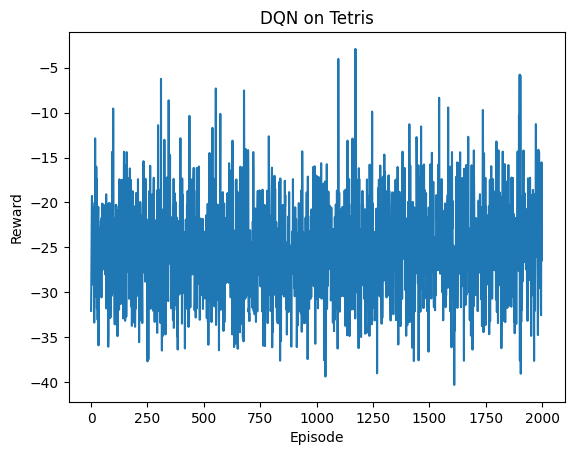

In [98]:
plt.plot(history)
plt.xlabel("Episode")
plt.ylabel("Reward")
plt.title("DQN on Tetris")
plt.show()

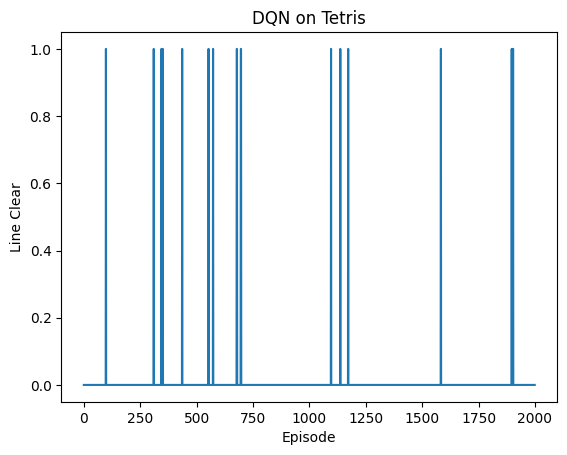

In [99]:
plt.plot(lines)
plt.xlabel("Episode")
plt.ylabel("Line Clear")
plt.title("DQN on Tetris")
plt.show()

In [100]:
def make_custom_tetris_env(
    alife=0.1,
    clear_line=50,
    game_over=-20,
    invalid_action=-1,
):

    # Create custom reward map
    custom_map = RewardsMapping(
        alife=alife,
        clear_line=clear_line,
        game_over=game_over,
        invalid_action=invalid_action
    )

    # Initialize env with reward override
    env = gym.make(
        "tetris_gymnasium/Tetris",
        rewards_mapping=custom_map,
        render_mode="rgb_array"  # Uncomment if needed
    )
    
    env = GroupedActionsObservations(env)
    
    return env

# Evaluate trained DQN and save gameplay video
device = next(q_net.parameters()).device  
env = make_custom_tetris_env()
video_path = "tetris_dqn_eval.mp4"
writer = imageio.get_writer(video_path, fps=30)
print(f"\n🎮 Evaluating trained agent for 10 episodes on {device}...\n")

for ep in range(10):
    state, _ = env.reset()
    done = False
    total_reward = 0
    lines_cleared = 0
    
    while not done:
        # Convert state to tensor and flatten (consistent with training)
        state_tensor = torch.tensor(state, dtype=torch.float32, device=device).unsqueeze(0)
        state_flat = state_tensor.flatten(start_dim=1)  # ✅ Match training preprocessing
        
        # Greedy action selection (no exploration)
        with torch.no_grad():
            q_values = q_net(state_flat)  # ✅ Use flattened state
            action = q_values.argmax(dim=1).item()  # ✅ Consistent with training
        
        # Step environment
        next_state, reward, terminated, truncated, info = env.step(action)
        done = terminated or truncated
        total_reward += reward
        lines_cleared += info.get("lines_cleared", 0)
        state = next_state
        
        # Render frame and add to video
        frame = env.render()
        writer.append_data(np.asarray(frame))
    
    print(f"Episode {ep+1}/10 | Total Reward: {total_reward:.2f} | Lines Cleared: {lines_cleared}")

writer.close()
env.close()
print(f"\n🎥 Video saved to {video_path}")



IMAGEIO FFMPEG_WRITER WARNING: input image is not divisible by macro_block_size=16, resizing from (340, 240) to (352, 240) to ensure video compatibility with most codecs and players. To prevent resizing, make your input image divisible by the macro_block_size or set the macro_block_size to 1 (risking incompatibility).



🎮 Evaluating trained agent for 10 episodes on cuda:0...

Episode 1/10 | Total Reward: -19.10 | Lines Cleared: 0
Episode 2/10 | Total Reward: 0.90 | Lines Cleared: 0
Episode 3/10 | Total Reward: -17.90 | Lines Cleared: 0
Episode 4/10 | Total Reward: -17.50 | Lines Cleared: 0
Episode 5/10 | Total Reward: 0.50 | Lines Cleared: 0
Episode 6/10 | Total Reward: -18.50 | Lines Cleared: 0
Episode 7/10 | Total Reward: 1.00 | Lines Cleared: 0
Episode 8/10 | Total Reward: -18.20 | Lines Cleared: 0
Episode 9/10 | Total Reward: -18.00 | Lines Cleared: 0
Episode 10/10 | Total Reward: -17.70 | Lines Cleared: 0

🎥 Video saved to tetris_dqn_eval.mp4


In [103]:
Video("tetris_dqn_eval.mp4", embed=True)